In [3]:
import numpy as np # generic math functions
import matplotlib.pyplot as plt
%matplotlib notebook
#%matplotlib inline

In [11]:
from quspin.operators import hamiltonian # Hamiltonians and operators
from quspin.basis import spin_basis_1d # Hilbert space spin basis
import numpy as np # generic math functions
import time

def Ham_nonint(L):
    basis = spin_basis_1d(L)
    hz=(np.sqrt(5)+1)/4 #parameters used by Kim and Huse
    hx=(np.sqrt(5)+5)/8
    J=1.0
    hz_arr = [[hz,i] for i in range(L)] 
    hx_arr = [[hx,i] for i in range(L)] 
    J_arr =[[J,i,(i+1)] for i in range(L-1)] # OBC  [[J,i,(i+1)%L] for i in range(L)] # PBC
    
    # static and dynamic lists
    static = [["zz",J_arr],["z",hz_arr], ["x",hx_arr] ]
    dynamic =[]
    H = hamiltonian(static,dynamic,basis=basis,dtype=np.float_,check_symm=False,check_herm=False)
    return H


def output_gauge_potent(Ham,L):
    E,V= Ham.eigh()
    op_lamb_arr = del_lambda_Ham(L).toarray()
    x=np.dot(op_lamb_arr, V)
    num_lamb_mat =np.dot(V.T,x) #matrix multiplication
    wij = np.outer(E,np.ones(2**L))-np.outer(np.ones(2**L),E)
    return wij, num_lamb_mat
  
def gauge_potent_mu(wij,num_lamb_mat,mu):
    A_lamb = -1j*np.multiply(wij,num_lamb_mat)/(wij**2+ mu**2)#element-wise multiplication
    return A_lamb


def del_lambda_Ham(L):
    basis = spin_basis_1d(L)  
    hx_lamb=1.0
    hx_lamb_arr = [[hx_lamb,i] for i in range(L)] 
    static_lamb = [["x",hx_lamb_arr]]
    dynamic_lamb =[]
    op_lamb=hamiltonian(static_lamb,dynamic_lamb,basis=basis,dtype=np.float_,check_symm=False,check_herm=False)
    return op_lamb

def norm(A_lamb):    
    return np.linalg.norm(A_lamb, 'fro')

### Transition rate without CD term

In [4]:
L=2
ham= Ham_nonint(L)
E,V= ham.eigh()
wij, num_lamb_mat= output_gauge_potent(ham,L)

In [13]:
print wij
print num_lamb_mat
#output should be index of energy levels    

[[ 0.         -1.30336868 -2.53739238 -5.37271366]
 [ 1.30336868  0.         -1.2340237  -4.06934498]
 [ 2.53739238  1.2340237   0.         -2.83532128]
 [ 5.37271366  4.06934498  2.83532128  0.        ]]
[[ -1.75338933e+00  -1.56699515e-16   3.17755325e-02  -7.88372607e-01]
 [ -1.33913398e-16   4.93038066e-32   2.77880993e-16   2.14811960e-16]
 [  3.17755325e-02   2.23770146e-16   7.70420912e-01   1.02974960e+00]
 [ -7.88372607e-01   2.20525963e-16   1.02974960e+00   9.82968415e-01]]


In [18]:
print np.where(np.abs(wij)>0.0)
print wij[np.where(np.abs(wij)>0.0)]
print num_lamb_mat[np.where(np.abs(wij)>0.0)]

(array([0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3]), array([1, 2, 3, 0, 2, 3, 0, 1, 3, 0, 1, 2]))
[-1.30336868 -2.53739238 -5.37271366  1.30336868 -1.2340237  -4.06934498
  2.53739238  1.2340237  -2.83532128  5.37271366  4.06934498  2.83532128]
[ -1.56699515e-16   3.17755325e-02  -7.88372607e-01  -1.33913398e-16
   2.77880993e-16   2.14811960e-16   3.17755325e-02   2.23770146e-16
   1.02974960e+00  -7.88372607e-01   2.20525963e-16   1.02974960e+00]


In [30]:
def delta(omega, omega_ij, tol):
    return np.where(np.abs(wij-omega)< tol)

di = np.diag_indices(2**L)
print np.diag(num_lamb_mat)
num_lamb_mat[di]=0.0
print np.diag(num_lamb_mat)

[ 0.  0.  0.  0.]
[ 0.  0.  0.  0.]


In [36]:
omega=0.0
tol=2.0
omega_ij=wij
x=delta(omega,omega_ij,tol)

In [42]:
print wij
print wij[x]
print num_lamb_mat
print num_lamb_mat[x]
print 'abs', np.abs(num_lamb_mat[x])**2
print 'sum', np.sum(np.abs(num_lamb_mat[x])**2)

[[ 0.         -1.30336868 -2.53739238 -5.37271366]
 [ 1.30336868  0.         -1.2340237  -4.06934498]
 [ 2.53739238  1.2340237   0.         -2.83532128]
 [ 5.37271366  4.06934498  2.83532128  0.        ]]
[ 0.         -1.30336868  1.30336868  0.         -1.2340237   1.2340237   0.
  0.        ]
[[  0.00000000e+00  -1.56699515e-16   3.17755325e-02  -7.88372607e-01]
 [ -1.33913398e-16   0.00000000e+00   2.77880993e-16   2.14811960e-16]
 [  3.17755325e-02   2.23770146e-16   0.00000000e+00   1.02974960e+00]
 [ -7.88372607e-01   2.20525963e-16   1.02974960e+00   0.00000000e+00]]
[  0.00000000e+00  -1.56699515e-16  -1.33913398e-16   0.00000000e+00
   2.77880993e-16   2.23770146e-16   0.00000000e+00   0.00000000e+00]
abs [  0.00000000e+00   2.45547379e-32   1.79327982e-32   0.00000000e+00
   7.72178465e-32   5.00730783e-32   0.00000000e+00   0.00000000e+00]
sum 1.69778460786e-31


In [76]:
omegaN_tot=200
L=10
tol=1e-5
ham= Ham_nonint(L)
E,V= ham.eigh()
wij, num_lamb_mat= output_gauge_potent(ham,L)

def delta(omega, omega_ij, tol):
    return np.where(np.abs(wij-omega)< tol)
#####
di = np.diag_indices(2**L)
#print np.diag(num_lamb_mat)
num_lamb_mat[di]=0.0
####
omega_max=2*L
omega_arr=np.linspace(-omega_max,omega_max,omegaN_tot)
avg_transition_arr=np.zeros(omegaN_tot)
omega_ij=wij
####
for i in range(omegaN_tot):
    omega=omega_arr[i]
    x=delta(omega,omega_ij,tol)
    avg_transition_arr[i]=np.sum(np.abs(num_lamb_mat[x])**2)/2**L

#print avg_transition_arr

In [3]:
omegaN_tot=200
L=10
tol=1e-3
ham= Ham_nonint(L)
E,V= ham.eigh()
wij, num_lamb_mat= output_gauge_potent(ham,L)

def delta(omega, omega_ij, tol):
    return np.where(np.abs(wij-omega)< tol)
#####
di = np.diag_indices(2**L)
#print np.diag(num_lamb_mat)
num_lamb_mat[di]=0.0
####
omega_max=2*L
omega_arr=np.linspace(-omega_max,omega_max,omegaN_tot)
avg_transition_arr_tol_thousandth=np.zeros(omegaN_tot)
omega_ij=wij
####
for i in range(omegaN_tot):
    omega=omega_arr[i]
    x=delta(omega,omega_ij,tol)
    avg_transition_arr_tol_thousandth[i]=np.sum(np.abs(num_lamb_mat[x])**2)/2**L

In [135]:
omegaN_tot=200
L=10
tol=1e-1
##
ham= Ham_nonint(L)
E,V= ham.eigh()
wij, num_lamb_mat= output_gauge_potent(ham,L)

def delta(omega, omega_ij, tol):
    return np.where(np.abs(wij-omega)< tol)
#####
di = np.diag_indices(2**L)
#print np.diag(num_lamb_mat)
num_lamb_mat[di]=0.0
####
omega_max=2*L
omega_arr=np.linspace(-omega_max,omega_max,omegaN_tot)
avg_transition_arr_tol_tenth=np.zeros(omegaN_tot)

omega_ij=wij
####
for i in range(omegaN_tot):
    omega=omega_arr[i]
    x=delta(omega,omega_ij,tol)
    #print x
    avg_transition_arr_tol_tenth[i]=np.sum(np.abs(num_lamb_mat[x])**2)/2**L

#print avg_transition_arr

In [78]:
omegaN_tot=200
L=10
tol=1e0
##
ham= Ham_nonint(L)
E,V= ham.eigh()
wij, num_lamb_mat= output_gauge_potent(ham,L)

def delta(omega, omega_ij, tol):
    return np.where(np.abs(wij-omega)< tol)
#####
di = np.diag_indices(2**L)
#print np.diag(num_lamb_mat)
num_lamb_mat[di]=0.0
####
omega_max=2*L
omega_arr=np.linspace(-omega_max,omega_max,omegaN_tot)
avg_transition_arr_tol_one=np.zeros(omegaN_tot)

omega_ij=wij
####
for i in range(omegaN_tot):
    omega=omega_arr[i]
    x=delta(omega,omega_ij,tol)
    #print x
    avg_transition_arr_tol_one[i]=np.sum(np.abs(num_lamb_mat[x])**2)/2**L

In [83]:
omegaN_tot=200
L=10
tol=1e1
##
ham= Ham_nonint(L)
E,V= ham.eigh()
wij, num_lamb_mat= output_gauge_potent(ham,L)

def delta(omega, omega_ij, tol):
    return np.where(np.abs(wij-omega)< tol)
#####
di = np.diag_indices(2**L)
#print np.diag(num_lamb_mat)
num_lamb_mat[di]=0.0
####
omega_max=2*L
omega_arr=np.linspace(-omega_max,omega_max,omegaN_tot)
avg_transition_arr_tol_ten=np.zeros(omegaN_tot)

omega_ij=wij
####
for i in range(omegaN_tot):
    omega=omega_arr[i]
    x=delta(omega,omega_ij,tol)
    #print x
    avg_transition_arr_tol_ten[i]=np.sum(np.abs(num_lamb_mat[x])**2)/2**L

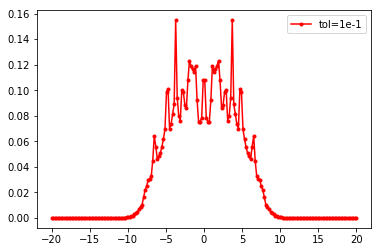

In [82]:
#plt.plot(omega_arr, avg_transition_arr, 'b.-', label="tol=1e-5")
plt.plot(omega_arr, avg_transition_arr_tol_tenth, 'r.-', label="tol=1e-1")
plt.legend()

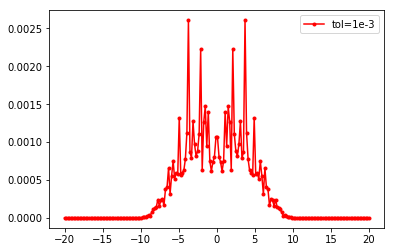

In [4]:
plt.plot(omega_arr, avg_transition_arr_tol_thousandth, 'r.-', label="tol=1e-3")
plt.legend()

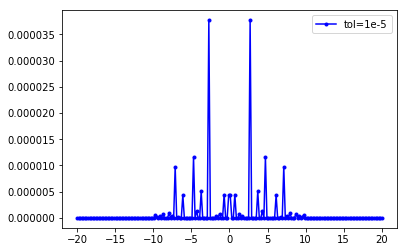

In [86]:
plt.plot(omega_arr, avg_transition_arr, 'b.-', label="tol=1e-5")
plt.legend()

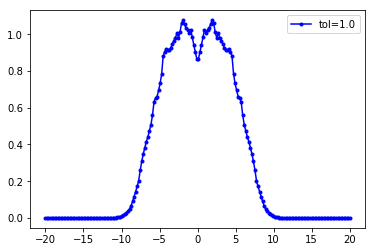

In [88]:
plt.plot(omega_arr, avg_transition_arr_tol_one, 'b.-', label="tol=1.0")
plt.legend()

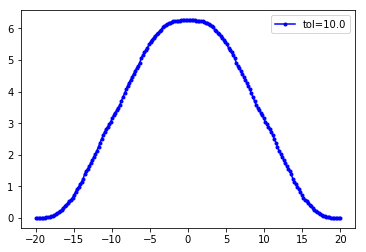

In [89]:
plt.plot(omega_arr, avg_transition_arr_tol_ten, 'b.-', label="tol=10.0")
plt.legend()

Above was transition rate without any CD term. Let's see what happens with CD term

### Transition rate with CD term

In [103]:
L=2
ham= Ham_nonint(L)
E,V= ham.eigh()
wij, num_lamb_mat= output_gauge_potent(ham,L)
tol=1e1
omega_ij=wij  
omega=1.0
x=delta(omega,omega_ij,tol)
print wij[x]
#print wij[x]**2
#print wij[x]**2 +mu**2
#mu=10.0
#print 1.0- wij[x]**2/( wij[x]**2 + mu**2)
print np.abs(num_lamb_mat[x])**2
#print np.abs(num_lamb_mat[x])**2*(1.0- wij[x]**2/( wij[x]**2 + mu**2))

[ 0.         -1.30336868 -2.53739238 -5.37271366  1.30336868  0.         -1.2340237
 -4.06934498  2.53739238  1.2340237   0.         -2.83532128  5.37271366
  4.06934498  2.83532128  0.        ]
[  3.07437413e+00   2.45547379e-32   1.00968446e-03   6.21531367e-01
   1.79327982e-32   2.43086534e-63   7.72178465e-32   4.61441781e-32
   1.00968446e-03   5.00730783e-32   5.93548381e-01   1.06038424e+00
   6.21531367e-01   4.86317003e-32   1.06038424e+00   9.66226906e-01]


In [147]:
omegaN_tot=200
L=10
tol=1e-1
####
mu=1e2
##
ham= Ham_nonint(L)
E,V= ham.eigh()
wij, num_lamb_mat= output_gauge_potent(ham,L)
###
def delta(omega, omega_ij, tol):
    return np.where(np.abs(wij-omega)< tol)
#####
di = np.diag_indices(2**L)
#print np.diag(num_lamb_mat)
num_lamb_mat[di]=0.0
####
omega_max=2*L
omega_arr=np.linspace(-omega_max,omega_max,omegaN_tot)
avg_transition_arr_tol_tenth_mu100=np.zeros(omegaN_tot)

omega_ij=wij
####
for i in range(omegaN_tot):
    omega=omega_arr[i]
    x=delta(omega,omega_ij,tol)
    trans_temp=np.abs(num_lamb_mat[x])**2*(1.0- wij[x]**2/( wij[x]**2 + mu**2))
    avg_transition_arr_tol_tenth_mu100[i]=np.sum(trans_temp)/2**L

In [148]:
omegaN_tot=200
L=10
tol=1e-1
####
mu=1e1
##
ham= Ham_nonint(L)
E,V= ham.eigh()
wij, num_lamb_mat= output_gauge_potent(ham,L)
###
def delta(omega, omega_ij, tol):
    return np.where(np.abs(wij-omega)< tol)
#####
di = np.diag_indices(2**L)
#print np.diag(num_lamb_mat)
num_lamb_mat[di]=0.0
####
omega_max=2*L
omega_arr=np.linspace(-omega_max,omega_max,omegaN_tot)
avg_transition_arr_tol_tenth_mu10=np.zeros(omegaN_tot)

omega_ij=wij
####
for i in range(omegaN_tot):
    omega=omega_arr[i]
    x=delta(omega,omega_ij,tol)
    trans_temp=np.abs(num_lamb_mat[x])**2*(1.0- wij[x]**2/( wij[x]**2 + mu**2))
    avg_transition_arr_tol_tenth_mu10[i]=np.sum(trans_temp)/2**L

In [149]:
omegaN_tot=200
L=10
tol=1e-1
####
mu=1e0
##
ham= Ham_nonint(L)
E,V= ham.eigh()
wij, num_lamb_mat= output_gauge_potent(ham,L)
###
def delta(omega, omega_ij, tol):
    return np.where(np.abs(wij-omega)< tol)
#####
di = np.diag_indices(2**L)
#print np.diag(num_lamb_mat)
num_lamb_mat[di]=0.0
####
omega_max=2*L
omega_arr=np.linspace(-omega_max,omega_max,omegaN_tot)
avg_transition_arr_tol_tenth_mu1=np.zeros(omegaN_tot)

omega_ij=wij
####
for i in range(omegaN_tot):
    omega=omega_arr[i]
    x=delta(omega,omega_ij,tol)
    trans_temp=np.abs(num_lamb_mat[x])**2*(1.0- wij[x]**2/( wij[x]**2 + mu**2))
    avg_transition_arr_tol_tenth_mu1[i]=np.sum(trans_temp)/2**L

In [151]:
omegaN_tot=200
L=10
tol=1e-1
####
mu=1e-1
##
ham= Ham_nonint(L)
E,V= ham.eigh()
wij, num_lamb_mat= output_gauge_potent(ham,L)
###
def delta(omega, omega_ij, tol):
    return np.where(np.abs(wij-omega)< tol)
#####
di = np.diag_indices(2**L)
#print np.diag(num_lamb_mat)
num_lamb_mat[di]=0.0
####
omega_max=2*L
omega_arr=np.linspace(-omega_max,omega_max,omegaN_tot)
avg_transition_arr_tol_tenth_mu_tenth=np.zeros(omegaN_tot)

omega_ij=wij
####
for i in range(omegaN_tot):
    omega=omega_arr[i]
    x=delta(omega,omega_ij,tol)
    trans_temp=np.abs(num_lamb_mat[x])**2*(1.0- wij[x]**2/( wij[x]**2 + mu**2))
    avg_transition_arr_tol_tenth_mu_tenth[i]=np.sum(trans_temp)/2**L

In [155]:
omegaN_tot=200
L=10
tol=1e-1
####
mu=1e-2
##
ham= Ham_nonint(L)
E,V= ham.eigh()
wij, num_lamb_mat= output_gauge_potent(ham,L)
###
def delta(omega, omega_ij, tol):
    return np.where(np.abs(wij-omega)< tol)
#####
di = np.diag_indices(2**L)
#print np.diag(num_lamb_mat)
num_lamb_mat[di]=0.0
####
omega_max=2*L
omega_arr=np.linspace(-omega_max,omega_max,omegaN_tot)
avg_transition_arr_tol_tenth_mu_hundredth=np.zeros(omegaN_tot)

omega_ij=wij
####
for i in range(omegaN_tot):
    omega=omega_arr[i]
    x=delta(omega,omega_ij,tol)
    trans_temp=np.abs(num_lamb_mat[x])**2*(1.0- wij[x]**2/( wij[x]**2 + mu**2))
    avg_transition_arr_tol_tenth_mu_hundredth[i]=np.sum(trans_temp)/2**L

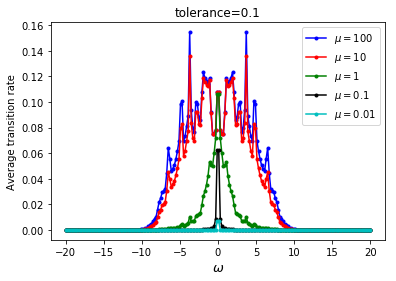

In [164]:
plt.plot(omega_arr, avg_transition_arr_tol_tenth_mu100, 'b.-', label=r"$\mu=100$")
plt.plot(omega_arr, avg_transition_arr_tol_tenth_mu10, 'r.-', label=r"$\mu=10$")
plt.plot(omega_arr, avg_transition_arr_tol_tenth_mu1, 'g.-', label=r"$\mu=1$")
plt.plot(omega_arr, avg_transition_arr_tol_tenth_mu_tenth, 'k.-', label=r"$\mu=0.1$")
plt.plot(omega_arr, avg_transition_arr_tol_tenth_mu_hundredth, 'c.-', label=r"$\mu=0.01$")
plt.legend()
plt.title("tolerance=0.1")
plt.xlabel(r"$\omega$", fontsize=13)
plt.ylabel(r"Average transition rate")
plt.savefig("transition_rate_high_tol.eps")

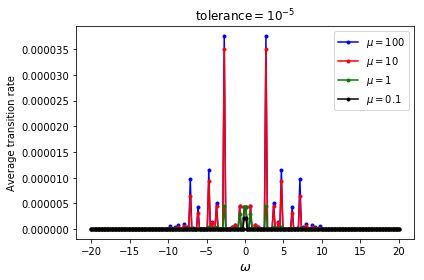

In [167]:
plt.plot(omega_arr, avg_transition_arr_mu100, 'b.-', label=r"$\mu=100$")
plt.plot(omega_arr, avg_transition_arr_mu10, 'r.-', label=r"$\mu=10$")
plt.plot(omega_arr, avg_transition_arr_mu1, 'g.-', label=r"$\mu=1$")
plt.plot(omega_arr, avg_transition_arr_mu_tenth, 'k.-', label=r"$\mu=0.1$")
#plt.plot(omega_arr, avg_transition_arr_tol_tenth_mu_hundredth, 'c.-', label=r"$\mu=0.01$")
plt.legend()
plt.title(r"tolerance$=10^{-5}$")
plt.xlabel(r"$\omega$", fontsize=13)
plt.ylabel(r"Average transition rate")
plt.tight_layout()
plt.savefig("transition_rate_low_tol.eps")

In [157]:
omegaN_tot=200
L=10
tol=1e-5
####
mu=1e2
##
ham= Ham_nonint(L)
E,V= ham.eigh()
wij, num_lamb_mat= output_gauge_potent(ham,L)
###
def delta(omega, omega_ij, tol):
    return np.where(np.abs(wij-omega)< tol)
#####
di = np.diag_indices(2**L)
#print np.diag(num_lamb_mat)
num_lamb_mat[di]=0.0
####
omega_max=2*L
omega_arr=np.linspace(-omega_max,omega_max,omegaN_tot)
avg_transition_arr_mu100=np.zeros(omegaN_tot)

omega_ij=wij
####
for i in range(omegaN_tot):
    omega=omega_arr[i]
    x=delta(omega,omega_ij,tol)
    trans_temp=np.abs(num_lamb_mat[x])**2*(1.0- wij[x]**2/( wij[x]**2 + mu**2))
    avg_transition_arr_mu100[i]=np.sum(trans_temp)/2**L

In [159]:
omegaN_tot=200
L=10
tol=1e-5
####
mu=1e1
##
ham= Ham_nonint(L)
E,V= ham.eigh()
wij, num_lamb_mat= output_gauge_potent(ham,L)
###
def delta(omega, omega_ij, tol):
    return np.where(np.abs(wij-omega)< tol)
#####
di = np.diag_indices(2**L)
#print np.diag(num_lamb_mat)
num_lamb_mat[di]=0.0
####
omega_max=2*L
omega_arr=np.linspace(-omega_max,omega_max,omegaN_tot)
avg_transition_arr_mu10=np.zeros(omegaN_tot)

omega_ij=wij
####
for i in range(omegaN_tot):
    omega=omega_arr[i]
    x=delta(omega,omega_ij,tol)
    trans_temp=np.abs(num_lamb_mat[x])**2*(1.0- wij[x]**2/( wij[x]**2 + mu**2))
    avg_transition_arr_mu10[i]=np.sum(trans_temp)/2**L

In [161]:
omegaN_tot=200
L=10
tol=1e-5
####
mu=1e0
##
ham= Ham_nonint(L)
E,V= ham.eigh()
wij, num_lamb_mat= output_gauge_potent(ham,L)
###
def delta(omega, omega_ij, tol):
    return np.where(np.abs(wij-omega)< tol)
#####
di = np.diag_indices(2**L)
#print np.diag(num_lamb_mat)
num_lamb_mat[di]=0.0
####
omega_max=2*L
omega_arr=np.linspace(-omega_max,omega_max,omegaN_tot)
avg_transition_arr_mu1=np.zeros(omegaN_tot)

omega_ij=wij
####
for i in range(omegaN_tot):
    omega=omega_arr[i]
    x=delta(omega,omega_ij,tol)
    trans_temp=np.abs(num_lamb_mat[x])**2*(1.0- wij[x]**2/( wij[x]**2 + mu**2))
    avg_transition_arr_mu1[i]=np.sum(trans_temp)/2**L

In [162]:
omegaN_tot=200
L=10
tol=1e-5
####
mu=1e-1
##
ham= Ham_nonint(L)
E,V= ham.eigh()
wij, num_lamb_mat= output_gauge_potent(ham,L)
###
def delta(omega, omega_ij, tol):
    return np.where(np.abs(wij-omega)< tol)
#####
di = np.diag_indices(2**L)
#print np.diag(num_lamb_mat)
num_lamb_mat[di]=0.0
####
omega_max=2*L
omega_arr=np.linspace(-omega_max,omega_max,omegaN_tot)
avg_transition_arr_mu_tenth=np.zeros(omegaN_tot)

omega_ij=wij
####
for i in range(omegaN_tot):
    omega=omega_arr[i]
    x=delta(omega,omega_ij,tol)
    trans_temp=np.abs(num_lamb_mat[x])**2*(1.0- wij[x]**2/( wij[x]**2 + mu**2))
    avg_transition_arr_mu_tenth[i]=np.sum(trans_temp)/2**L

### Dissipation rate

In [177]:
L=2
ham= Ham_nonint(L)
E,V= ham.eigh()
wij, num_lamb_mat= output_gauge_potent(ham,L)
print wij
print wij[0,:]
print wij[1,:]
print num_lamb_mat
print num_lamb_mat[0,:]

[[ 0.         -1.30336868 -2.53739238 -5.37271366]
 [ 1.30336868  0.         -1.2340237  -4.06934498]
 [ 2.53739238  1.2340237   0.         -2.83532128]
 [ 5.37271366  4.06934498  2.83532128  0.        ]]
[ 0.         -1.30336868 -2.53739238 -5.37271366]
[ 1.30336868  0.         -1.2340237  -4.06934498]
[[ -1.75338933e+00  -1.56699515e-16   3.17755325e-02  -7.88372607e-01]
 [ -1.33913398e-16   4.93038066e-32   2.77880993e-16   2.14811960e-16]
 [  3.17755325e-02   2.23770146e-16   7.70420912e-01   1.02974960e+00]
 [ -7.88372607e-01   2.20525963e-16   1.02974960e+00   9.82968415e-01]]
[ -1.75338933e+00  -1.56699515e-16   3.17755325e-02  -7.88372607e-01]


In [178]:
####
mu=1e2
L=10
ntot=2**L
##
ham= Ham_nonint(L)
E,V= ham.eigh()
wij, num_lamb_mat= output_gauge_potent(ham,L)
####
di = np.diag_indices(2**L)
num_lamb_mat[di]=0.0
####

dissipation_arr_100=np.zeros(ntot)

omega_ij=wij
####
for i in range(ntot):
    num_lamb_mat_temp=num_lamb_mat[i,:]
    wij_temp=wij[i,:]
    diss_temp=mu**4*np.abs(num_lamb_mat_temp)**2*(wij_temp**2/( wij_temp**2 + mu**2)**2)
    dissipation_arr_100[i]=np.sum(diss_temp)

In [182]:
####
mu=1e1
L=10
ntot=2**L
##
ham= Ham_nonint(L)
E,V= ham.eigh()
wij, num_lamb_mat= output_gauge_potent(ham,L)
####
di = np.diag_indices(2**L)
num_lamb_mat[di]=0.0
####

dissipation_arr_10=np.zeros(ntot)

omega_ij=wij
####
for i in range(ntot):
    num_lamb_mat_temp=num_lamb_mat[i,:]
    wij_temp=wij[i,:]
    diss_temp=mu**4*np.abs(num_lamb_mat_temp)**2*(wij_temp**2/( wij_temp**2 + mu**2)**2)
    dissipation_arr_10[i]=np.sum(diss_temp)

In [195]:
####
mu=0.5*1e1
L=10
ntot=2**L
##
ham= Ham_nonint(L)
E,V= ham.eigh()
wij, num_lamb_mat= output_gauge_potent(ham,L)
####
di = np.diag_indices(2**L)
num_lamb_mat[di]=0.0
####

dissipation_arr_5=np.zeros(ntot)

omega_ij=wij
####
for i in range(ntot):
    num_lamb_mat_temp=num_lamb_mat[i,:]
    wij_temp=wij[i,:]
    diss_temp=mu**4*np.abs(num_lamb_mat_temp)**2*(wij_temp**2/( wij_temp**2 + mu**2)**2)
    dissipation_arr_5[i]=np.sum(diss_temp)

In [186]:
####
mu=1e0
L=10
ntot=2**L
##
ham= Ham_nonint(L)
E,V= ham.eigh()
wij, num_lamb_mat= output_gauge_potent(ham,L)
####
di = np.diag_indices(2**L)
num_lamb_mat[di]=0.0
####

dissipation_arr_1=np.zeros(ntot)

omega_ij=wij
####
for i in range(ntot):
    num_lamb_mat_temp=num_lamb_mat[i,:]
    wij_temp=wij[i,:]
    diss_temp=mu**4*np.abs(num_lamb_mat_temp)**2*(wij_temp**2/( wij_temp**2 + mu**2)**2)
    dissipation_arr_1[i]=np.sum(diss_temp)

In [187]:
####
mu=1e-1
L=10
ntot=2**L
##
ham= Ham_nonint(L)
E,V= ham.eigh()
wij, num_lamb_mat= output_gauge_potent(ham,L)
####
di = np.diag_indices(2**L)
num_lamb_mat[di]=0.0
####

dissipation_arr_tenth=np.zeros(ntot)

omega_ij=wij
####
for i in range(ntot):
    num_lamb_mat_temp=num_lamb_mat[i,:]
    wij_temp=wij[i,:]
    diss_temp=mu**4*np.abs(num_lamb_mat_temp)**2*(wij_temp**2/( wij_temp**2 + mu**2)**2)
    dissipation_arr_tenth[i]=np.sum(diss_temp)

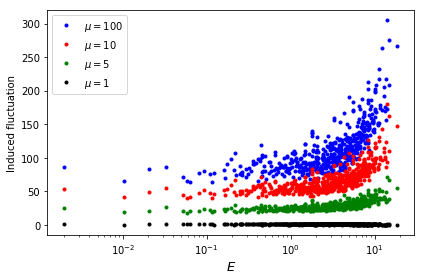

In [199]:
plt.semilogx(E, dissipation_arr_100, 'b.', label=r"$\mu=100$")
plt.semilogx(E, dissipation_arr_10, 'r.', label=r"$\mu=10$")
plt.semilogx(E, dissipation_arr_5, 'g.', label=r"$\mu=5$")
plt.semilogx(E, dissipation_arr_1, 'k.', label=r"$\mu=1$")
plt.legend()
plt.xlabel(r"$E$", fontsize=13)
plt.ylabel(r"Induced fluctuation")
plt.tight_layout()
plt.savefig("dissipation_rate.eps")

### Average dissipation rate

In [26]:
####
muTot=200
mu=np.logspace(-5,5,muTot)
L=10
ntot=2**L
##
ham= Ham_nonint(L)
E,V= ham.eigh()
wij, num_lamb_mat= output_gauge_potent(ham,L)
####
di = np.diag_indices(2**L)
num_lamb_mat[di]=0.0
####


avg_dissipation_arr=np.zeros(muTot)
omega_ij=wij
####
for j in range(muTot):
    dissipation_arr=np.zeros(ntot)
    for i in range(ntot):
        num_lamb_mat_temp=num_lamb_mat[i,:]
        wij_temp=wij[i,:]
        diss_temp=mu[j]**4*np.abs(num_lamb_mat_temp)**2*(wij_temp**2/( wij_temp**2 + mu[j]**2)**2)
        dissipation_arr[i]=np.sum(diss_temp)
    avg_dissipation_arr[j]=np.sum(dissipation_arr)/ntot
    #print mu[j], avg_dissipation_arr[j]

In [21]:
print avg_dissipation_arr[-1]

98.1803398875


In [27]:
####
muTot=200
mu=np.logspace(-5,5,muTot)
L=9
ntot=2**L
##
ham= Ham_nonint(L)
E,V= ham.eigh()
wij, num_lamb_mat= output_gauge_potent(ham,L)
####
di = np.diag_indices(2**L)
num_lamb_mat[di]=0.0
####


avg_dissipation_arr_L9=np.zeros(muTot)
omega_ij=wij
####
for j in range(muTot):
    dissipation_arr=np.zeros(ntot)
    for i in range(ntot):
        num_lamb_mat_temp=num_lamb_mat[i,:]
        wij_temp=wij[i,:]
        diss_temp=mu[j]**4*np.abs(num_lamb_mat_temp)**2*(wij_temp**2/( wij_temp**2 + mu[j]**2)**2)
        dissipation_arr[i]=np.sum(diss_temp)
    avg_dissipation_arr_L9[j]=np.sum(dissipation_arr)/ntot
    #print mu[j], avg_dissipation_arr[j]

In [29]:
####
muTot=200
mu=np.logspace(-5,5,muTot)
L=8
ntot=2**L
##
ham= Ham_nonint(L)
E,V= ham.eigh()
wij, num_lamb_mat= output_gauge_potent(ham,L)
####
di = np.diag_indices(2**L)
num_lamb_mat[di]=0.0
####


avg_dissipation_arr_L8=np.zeros(muTot)
omega_ij=wij
####
for j in range(muTot):
    dissipation_arr=np.zeros(ntot)
    for i in range(ntot):
        num_lamb_mat_temp=num_lamb_mat[i,:]
        wij_temp=wij[i,:]
        diss_temp=mu[j]**4*np.abs(num_lamb_mat_temp)**2*(wij_temp**2/( wij_temp**2 + mu[j]**2)**2)
        dissipation_arr[i]=np.sum(diss_temp)
    avg_dissipation_arr_L8[j]=np.sum(dissipation_arr)/ntot

<IPython.core.display.Javascript object>


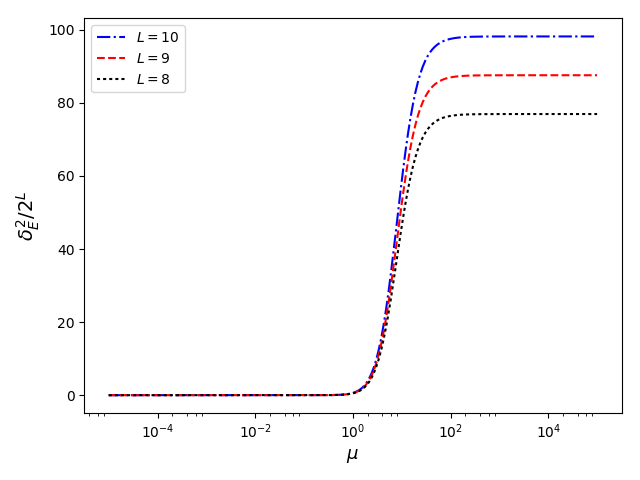

In [39]:
plt.semilogx(mu, avg_dissipation_arr, 'b-.', label=r"$L=10$")
#plt.semilogx(mu, theor_exp(10)*np.ones(muTot)/10.0, 'g-', label=r"$Theor.$")
plt.semilogx(mu, avg_dissipation_arr_L9, 'r--', label=r"$L=9$")
plt.semilogx(mu, avg_dissipation_arr_L8, 'k:', label=r"$L=8$")
plt.legend()
plt.xlabel(r"$\mu$", fontsize=13)
plt.ylabel(r"$\delta^2_E/2^L $", fontsize=14)
plt.tight_layout()
plt.savefig("avg_dissipation_rate_2.eps")

In [22]:
L=10

def theor_exp(L):
    hz=(np.sqrt(5)+1)/4 #parameters used by Kim and Huse
    hx=(np.sqrt(5)+5)/8
    return 4* (hz**2*L+ 2*(L-1))

In [19]:
print theo

104.725424859
